In [1]:
import json

import bz2
import regex
from tqdm import tqdm
from scipy import sparse

In [2]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [01:14, 2689.97it/s]


## Часть 1. Анализ текстов

### Посчитайте количество отзывов в разных городах и на разные банки

In [136]:
def CBCount(data):
    cans = {}
    bans = {}
    for line in data:
        city = line['city']
        bank = line['bank_name']
        if city in cans:
            cans[city] += 1
        else:
            cans[city] = 1
        if bank in bans:
            bans[bank] += 1
        else:
            bans[bank] = 1
    return cans, bans
cresp, bresp = CBCount(responses) 

In [137]:
print(cresp)

{'г. Москва': 55354, 'г. Новосибирск': 2300, 'г. Ставрополь': 696, 'г. Челябинск': 1507, 'г. Волгоград': 1014, 'г. Пермь': 1163, 'г. Ростов-на-Дону': 1891, 'г. Воронеж': 1210, 'г. Таганрог (Ростовская обл.)': 8, 'г. Санкт-Петербург': 14342, 'г. Конаково': 9, 'г. Мурманск': 434, 'г. Волгодонск (Ростовская обл.)': 7, 'г. Большеречье': 2, 'г. Одинцово (Московская обл.)': 8, 'г. Салават (Республика Башкортостан)': 4, 'г. Краснодар': 1262, 'г. Кострома': 160, 'г. Нижний Новгород': 1976, 'г. Орел': 234, 'г. Саратов': 933, 'г. Казань': 1440, 'г. Реутов (Московская обл.)': 3, 'г. Ульяновск': 500, 'г. Красноярск': 1236, 'г. Хабаровск': 681, 'г. Магнитогорск (Челябинская обл.)': 16, 'г. Фролово (Волгоградская обл.)': 1, 'г. Новочеркасск': 67, 'г. Чита': 126, 'г. таганрог': 8, 'г. Йошкар-Ола': 190, 'г. Нижний Тагил': 189, 'г. Ханты-Мансийск': 48, 'г. Россия': 204, 'г. Липецк': 461, 'г. Нижнекамск (Республика Татарстан)': 5, 'г. Тюмень': 656, 'г. Москва, Санкт-Петербург': 3, 'г. Кизел': 2, 'г. Мон

In [138]:
print(bresp)

{'Бинбанк': 1646, 'Сбербанк России': 26327, 'ОТП Банк': 3237, 'Гагаринский': 19, 'Тинькофф Банк': 5387, 'Восточный Экспресс Банк': 3138, 'ВТБ 24': 8185, 'Альфа-Банк': 10224, 'БИНБАНК кредитные карты': 1464, 'МТС Банк': 1870, 'Совкомбанк': 919, 'Россельхозбанк': 532, 'Московский Кредитный Банк': 2944, 'МДМ Банк': 776, 'Хоум Кредит Банк': 7549, 'Бенифит-Банк': 115, 'Уральский Банк Реконструкции и Развития': 532, 'Русский Стандарт': 7943, 'Лето Банк': 501, 'Петрокоммерц': 339, 'Русфинанс Банк': 723, 'Киви Банк': 1741, 'Ханты-Мансийский банк Открытие': 2158, 'Русславбанк': 715, 'Татфондбанк': 159, 'МАСТ-Банк': 208, 'Национальный Банк «Траст»': 4607, 'Военно-Промышленный Банк': 149, 'АктивКапитал Банк': 75, 'Связной Банк': 3775, 'Платежный Центр': 13, 'Московский Индустриальный Банк': 271, 'Финансовый Стандарт': 125, 'Ренессанс Кредит': 3849, 'Югра': 451, 'ЮниКредит Банк': 2488, 'Банкирский Дом': 43, 'Кредит Европа Банк': 1683, 'Тройка-Д Банк': 13, 'ДельтаКредит': 501, 'Сетелем Банк': 1351,

In [5]:
!pip install pymystem3

### Постройте кривые Ципфа и Хипса

No handles with labels found to put in legend.


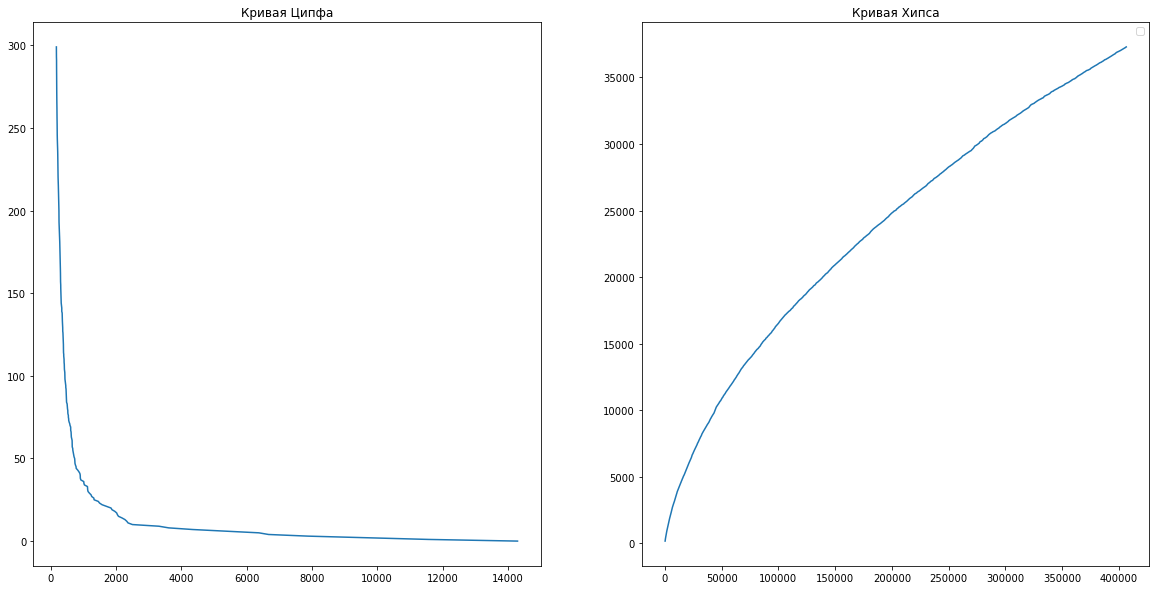

In [142]:
from string import punctuation
from nltk.tokenize import word_tokenize
from collections import Counter
import re
from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer
def CharCount(data, choise = 0):
    n_words = []
    n_tokens = []
    ans = Counter()
    if choise == 0:
        spec_chars = punctuation + '\n\xa0«»\t—…'
    elif choise == 1 or choise == 2:
        spec_chars = str()
        spec_chars = set(stopwords.words('russian'))
        spec_chars.update(list(punctuation + '\n\xa0«»\t—…'))
        spec_chars.update(['...', '``', "''", ' \xa0', ' ', '  ', '\xa0 '])
    inds = 2000
    if choise == 2:
        inds = 1000
    for text in data[:inds]:
        text = text['text'].lower()
        if choise == 2:
            pymorphy2_analyzer = MorphAnalyzer()
            text = re.sub('[{}]'.format(punctuation), '', text)
            text = [pymorphy2_analyzer.parse(word)[0].normal_form for word in text.split()]
            text = str(' '.join(text))
        ans.update([token for token in word_tokenize(text) if token not in spec_chars and len(token) < 30])
        n_words.append(len(ans))
        n_tokens.append(sum(list(ans.values())))
    if choise == 0:
        return ans, n_words, n_tokens
    else:
        return ans
Cword, nw, nt = CharCount(responses)

freqs = list(Cword.values())
freqs = sorted(freqs, reverse = True)

plt.figure(figsize = (20, 10))
plt.subplot(1, 2, 1)
plt.title('Кривая Ципфа')
plt.plot(freqs[:300], range(300))
plt.subplot(1, 2, 2)
plt.title('Кривая Хипса')
plt.plot(nt, nw)
plt.legend()

### Постройте гистограмы длин слов в символах

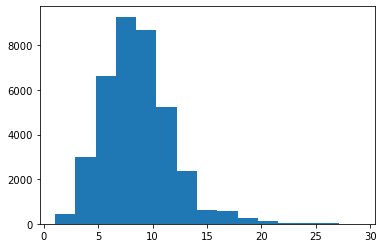

In [7]:
ans = []
for word in Cword:
    size = len(word)
    ans.append(int(size))
plt.hist(ans, bins = 15)
plt.show()

### Найдите 10 самых частых:
#### 1) слов
#### 2) слов без стоп-слов
#### 3) лемм
#### 4) существительных

In [8]:
print('10 самых частых слов:', *Cword.most_common(10))
WithOutStops = CharCount(responses, choise = 1)
print('10 самых частых слов без стоп-слов:', *WithOutStops.most_common(10))
Lemms = CharCount(responses, choise = 2)
print('10 самых частых лемм:', *Lemms.most_common(10))

10 самых частых слов: ('в', 14297) ('и', 11573) ('не', 9678) ('на', 7879) ('что', 6669) ('я', 6373) ('с', 5351) ('по', 4347) ('мне', 3610) ('банка', 3311)
10 самых частых слов без стоп-слов: ('банка', 3311) ('банк', 2500) ('это', 1960) ('деньги', 1325) ('карты', 1232) ('карту', 1140) ('кредит', 900) ('день', 888) ('года', 777) ('заявление', 740)
10 самых частых лемм: ('банк', 3825) ('карта', 1782) ('это', 1578) ('всё', 946) ('кредит', 923) ('который', 850) ('деньга', 836) ('день', 825) ('вклад', 811) ('клиент', 727)


### Ответьте на следующие вопросы:
#### 1) какое слово встречается чаще, "сотрудник" или "клиент"?
#### 2) сколько раз встречается слова "мошенничество" и "доверие"?

In [9]:
print('Слово сотрудник встречается:', Lemms['сотрудник'], 'раз')
print('Слово клиент встречается:', Lemms['клиент'], 'раз')
print('Слово мошенничество встречается:', Lemms['мошенничество'], 'раз')
print('Слово доверие встречается:', Lemms['доверие'], 'раз')

Слово сотрудник встречается: 720 раз
Слово клиент встречается: 727 раз
Слово мошенничество встречается: 19 раз
Слово доверие встречается: 32 раз


### 1) Слово клиент встречается чаще, нежели сотрудник
### 2) Слово мошенничество встречается: 19 раз. Слово доверие встречается: 32 раз

### В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру tf-idf, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [10]:
m = MorphAnalyzer()

mystopwords = stopwords.words('russian') + [
    'это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д',
    'который','прошлый','сей', 'свой', 'наш', 'мочь', 'такой'
]
ru_words = re.compile("[А-Яа-я]+")


def words_only(text):
    return " ".join(ru_words.findall(text))


def lemmatize(text):
    try:
        return  " ".join([m.parse(w)[0].normal_form for w in text.lower().split()])
    except:
        return " "


def remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

    
def preprocess(text):
    return remove_stopwords(lemmatize(words_only(text.lower())))

In [11]:
badresp = list(line['text'] for line in responses if line['rating_grade'] == 1)
goodresp = list(line['text'] for line in responses if line['rating_grade'] == 5)
print(len(badresp))
print(len(goodresp))

47387
14713


In [ ]:
badresp = list(preprocess(text) for text in badresp[:800])
goodresp = list(preprocess(text) for text in goodresp[:800])

In [63]:
from sklearn.feature_extraction.text import TfidfVectorizer
def keywords(resp):
    vec = TfidfVectorizer(analyzer='word', ngram_range=(1,2), min_df = 0)
    bow = vec.fit_transform(resp)
    dense = bow.todense().tolist()
    vecs = []
    for i in range(len(dense[0])):
        sums = 0.0
        for j in range(len(dense)):
            sums += dense[j][i]
        vecs.append(sums)
    feature_names = vec.get_feature_names() 
    phrase_scores = [pair for pair in zip(range(0, len(vecs)), vecs)]
    sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
    tfidf_ranking = []
    for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:40]:
        tfidf_ranking.append(phrase)
    rankings = pd.DataFrame({'tf-idf': tfidf_ranking})
    return rankings

In [64]:
bdf = keywords(badresp)
gdf = keywords(goodresp)

### Ключевые слова для отрицательных отзывов

In [144]:
bdf.head(20)

,tf-idf
0,банк
1,карта
2,деньга
3,кредит
4,отделение
5,сотрудник
6,день
7,заявление
8,счёт
9,вклад


### Ключевые слова для положительных отзывов

In [143]:
gdf.head(20)

,tf-idf
0,банк
1,карта
2,вклад
3,всё
4,отделение
5,сотрудник
6,очень
7,клиент
8,день
9,офис


## Часть 2. Тематическое моделирование

### Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.

In [91]:
clresp = list(preprocess(line['text']) for line in responses[:1500])

In [92]:
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim.models import lsimodel
import gensim

def vect2gensim(vectorizer, dtmatrix):
     # transform sparse matrix into gensim corpus and dictionary
    corpus_vect_gensim = gensim.matutils.Sparse2Corpus(dtmatrix, documents_columns=False)
    dictionary = Dictionary.from_corpus(corpus_vect_gensim,
        id2word=dict((ids, word) for word, ids in vectorizer.vocabulary_.items()))
    
    return (corpus_vect_gensim, dictionary)
    
vec = TfidfVectorizer(analyzer='word', ngram_range=(1,2), min_df = 0)
corpus_tfidf = vec.fit_transform(clresp)
(gensim_corpus, gensim_dict) = vect2gensim(vec, corpus_tfidf)

In [109]:
lsi = lsimodel.LsiModel(corpus=gensim_corpus, id2word=gensim_dict, num_topics=30)
lsi.show_topics(5)

[(0,
  '-0.341*"банк" + -0.269*"карта" + -0.150*"кредит" + -0.132*"деньга" + -0.126*"вклад" + -0.120*"день" + -0.115*"сотрудник" + -0.107*"всё" + -0.107*"счёт" + -0.105*"сумма"'),
 (1,
  '-0.240*"вклад" + -0.238*"карта" + 0.217*"звонок" + 0.209*"номер" + 0.163*"телефон" + 0.163*"кредит" + 0.146*"ваш" + 0.127*"номер телефон" + 0.126*"данные" + 0.121*"персональный"'),
 (2,
  '0.559*"вклад" + -0.321*"карта" + 0.234*"ставка" + 0.180*"пополнение" + 0.164*"условие" + 0.149*"договор" + 0.123*"банк" + -0.098*"сбербанк" + 0.095*"пополнение вклад" + 0.084*"процент"'),
 (3,
  '-0.369*"карта" + 0.357*"кредит" + 0.207*"страховка" + 0.160*"страхование" + -0.139*"вклад" + 0.135*"договор" + -0.115*"номер" + 0.112*"платёж" + 0.104*"погашение" + 0.096*"сумма"'),
 (4,
  '-0.138*"средство" + -0.134*"сумма" + -0.131*"сбербанк" + -0.129*"денежный" + -0.128*"денежный средство" + 0.127*"звонить" + 0.126*"звонок" + 0.126*"банк" + -0.126*"деньга" + 0.125*"ваш"')]

### Примеры интерпретируемых тем: кредитная карта, пополнение вклада

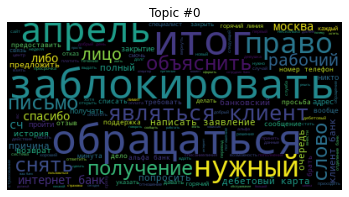

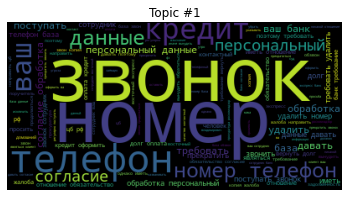

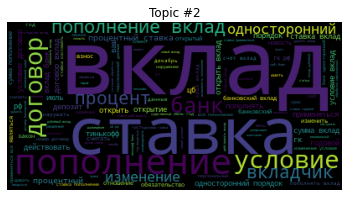

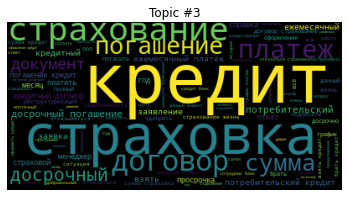

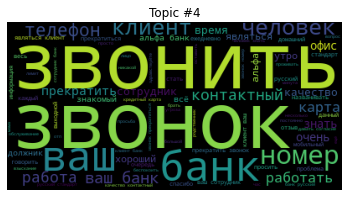

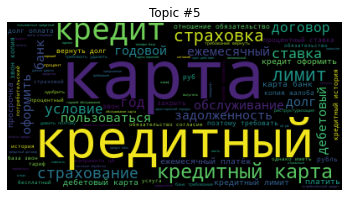

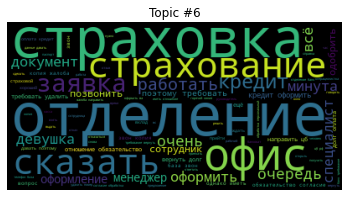

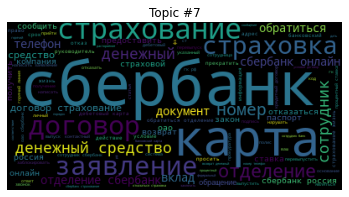

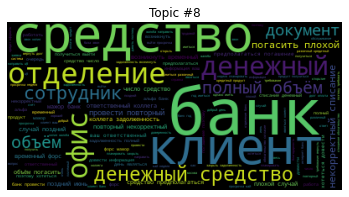

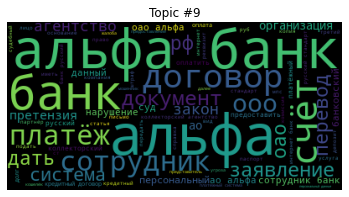

In [110]:
from wordcloud import WordCloud
for t in range(10):
    plt.figure()
    plt.imshow(WordCloud().fit_words(dict(lsi.show_topic(t, 200))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()

### Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить? Эта часть задания может быть сделана с использованием gensim.

### По облаку слов видны тексты, в которых названия банков являются темами(Сбербанк, Альфабанк). Предполагаю, что их выделение в качестве темы является прямой связью работы клиента, по которой написан отзыв, с услугами конкретного банка

## Часть 3. Классификация текстов

### Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5).

### 1) Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте sklearn.model_selection.train_test_split для разделения множества отобранных документов на обучающее и тестовое.
### 2) Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных -грам.
### Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
### 1-ый вариант:  преобразование (sklearn.feature_extraction.text.TfidfTransformer) и сингулярное разложение (оно же – латентый семантический анализ) (sklearn.decomposition.TruncatedSVD)

In [124]:
xtext = badresp + goodresp
ytext = []
for i in range(800):
    ytext.append(0)
for i in range(800):
    ytext.append(1)

In [133]:
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

def Analize(text, ans):
    X_train, X_test, y_train, y_test = train_test_split(text, ans)
    for i in range(1, 5):
        tfmodel = TfidfVectorizer(analyzer='word', ngram_range=(1,i), min_df = 0).fit(text)
        vecs = tfmodel.transform(text)
        SVD = TruncatedSVD(n_components=5, random_state=0).fit(vecs)
        trvecs = tfmodel.transform(X_train)
        trvecs = SVD.transform(trvecs)
        testvecs = tfmodel.transform(X_test)
        testvecs = SVD.transform(testvecs)
        clf = LogisticRegression(random_state=42, solver='liblinear')
        clf.fit(trvecs, y_train)
        pred = clf.predict(testvecs)
        print(classification_report(pred, y_test))

In [134]:
Analize(xtext, ytext)

              precision    recall  f1-score   support

           0       0.80      0.81      0.80       202
           1       0.80      0.79      0.79       198

    accuracy                           0.80       400
   macro avg       0.80      0.80      0.80       400
weighted avg       0.80      0.80      0.80       400

              precision    recall  f1-score   support

           0       0.77      0.81      0.79       194
           1       0.81      0.77      0.79       206

    accuracy                           0.79       400
   macro avg       0.79      0.79      0.79       400
weighted avg       0.79      0.79      0.79       400

              precision    recall  f1-score   support

           0       0.76      0.83      0.79       189
           1       0.83      0.77      0.80       211

    accuracy                           0.80       400
   macro avg       0.80      0.80      0.79       400
weighted avg       0.80      0.80      0.80       400

              preci

### Не было сил и идей по внедрению скрытых тем в качестве признаков, поэтому обошёлся без них. По репортам для моделей с использованием конструкций разной сложности(униграммы, биграммы и т.д.) видно, что нет какого-то сильного различия в точности между отдельными примерами, следовательно в данной задаче можно спокойно использовать только униграммы, так как точность не теряется, а время работы программного кода уменьшается